# Analysis of advertising effectiveness

Objectives of the analysis are to understand the following:
- where users come from and what devices they use,
- how much it costs to attract users from different advertising channels,
- how much money each client brings in,
- when the cost of attracting a customer pays off,
- what are the factors that hinder attracting customers.

**Summary** 
The data from the mobile app was analyzed. Various metrics were calculated and cohort analysis was used: LTV, CAC, Retention rate, DAU, WAU, MAU, etc. Conclusions were made about advertising costs.

## preparation

### import libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

### read data

In [34]:
# read data from csv
try:
    visits_df = pd.read_csv('datasets/visits_info_short.csv')
    orders_df = pd.read_csv('datasets/orders_info_short.csv')
    costs_df = pd.read_csv('datasets/costs_info_short.csv')
except:
    visits_df = pd.read_csv('datasets\\visits_info_short.csv')
    orders_df = pd.read_csv('datasets\\orders_info_short.csv')
    costs_df = pd.read_csv('datasets\\costs_info_short.csv')

## Initial Data Analysis

### data cleaning for 'visits'

In [35]:
visits_df = visits_df.rename(columns={
    'User Id':'user_id',
    'Region':'region',
    'Device':'device',
    'Channel':'channel',
    'Session Start':'session_start',
    'Session End':'session_end'
})
visits_df.session_start = pd.to_datetime(visits_df.session_start)
visits_df.session_end = pd.to_datetime(visits_df.session_end)

print('number of duplicates', visits_df.duplicated().sum())
print('number of null', visits_df.isna().sum())
visits_df.head()


number of duplicates 0
number of null user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


### data cleaning for 'orders'

In [36]:
orders_df = orders_df.rename(columns={
    'User Id':'user_id',
    'Event Dt':'event_dt',
    'Revenue':'revenue'
    })
orders_df.event_dt = pd.to_datetime(orders_df.event_dt)

print('number of duplicates', orders_df.duplicated().sum())
print('number of null', orders_df.isna().sum())

display(orders_df[orders_df.duplicated()])
display(orders_df.query('user_id.isin([786994605844, 658065077014])'))

number of duplicates 0
number of null user_id     0
event_dt    0
revenue     0
dtype: int64


,user_id,event_dt,revenue


,user_id,event_dt,revenue
15459,658065077014,2019-08-31 13:54:34,4.99
15627,658065077014,2019-09-01 19:03:11,4.99
16548,658065077014,2019-09-06 23:25:50,4.99
16717,658065077014,2019-09-07 06:14:24,4.99
20067,658065077014,2019-09-26 00:00:05,4.99
20256,658065077014,2019-09-26 12:16:54,4.99
22474,658065077014,2019-10-06 17:52:02,4.99
24811,658065077014,2019-10-17 14:36:08,4.99
25617,786994605844,2019-10-21 00:00:13,4.99
25840,786994605844,2019-10-21 01:22:06,4.99


Found 2 duplicates in the orders, but their presence is justified. There is no need to delete them

### data cleaning for 'costs'

In [37]:
costs_df = costs_df.rename(columns={
    'dt':'dt', 
    'Channel':'channel'
})
costs_df['dt'] = pd.to_datetime(costs_df['dt']).dt.date

print('number of duplicates', visits_df.duplicated().sum())
print('number of null', visits_df.isna().sum())



number of duplicates 0
number of null user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


### functions to calculate and analyze LTV, ROI, retention and conversions.

functions to calculate metrics values:

- `get_profiles()` - to create user profiles,
- `get_retention()` - to calculate Retention Rate,
- `get_conversion()` - for conversion calculation,
- `get_ltv()` - for LTV calculation.

Functions for charts:

- `filter_data()` - for smoothing data,
- `plot_retention()` - for plotting Retention Rate,
- `plot_conversion()` - for plotting Retention Rate,
- `plot_ltv_roi` - for visualizing LTV and ROI.

#### `get_profiles`

In [38]:
new_pro = (
    visits_df.sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg(
        {
            'session_start': 'first',
            'channel': 'first',
            'device': 'first',
            'region': 'first',
        }
    )
    .rename(columns={'session_start': 'first_ts'})
    .reset_index()
)
new_pro['dt'] = new_pro.first_ts.dt.date

display(new_pro)

,user_id,first_ts,channel,device,region,dt
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02
...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28


In [39]:
sessions=visits_df
orders=orders_df
ad_costs=costs_df

In [40]:
def get_profiles_short(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles.user_id.isin(orders.user_id.unique())

    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
            # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
        
    return profiles


In [41]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

#### `get_retention`

In [42]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### `get_conversion`

In [43]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### `get_LTV_ROI`

In [44]:
def get_ltv_roi(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### `filter_data`

In [45]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### `plot_retention`

In [46]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 6))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### `plot_conversion`

In [47]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 3))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### `plot_LTV_ROI`

In [48]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 8))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis

Objectives
- Create user profiles. Determine the minimum and maximum dates for attracting users.
- Find out which countries users come to the app from and which country has the most paying users. Build a table showing the number of users and the share of paying users from each country.
- Find out what devices customers use and what devices payers prefer. Build a table showing the number of users and the share of paying users for each device.
- Explore advertising sources of engagement and identify the channels from which the most paying users came. Build a table showing the number of users and the share of paying users for each engagement channel.

### user profiles

In [49]:
profiles = get_profiles_short(sessions=visits_df, orders=orders_df, ad_costs=costs_df)
display(profiles.sample(5))

print('Минимальная дата привлечения пользователей', profiles.dt.min())
print('Максимальная дата привлечения пользователей', profiles.dt.max())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
39078,259487588036,2019-08-04 14:41:09,FaceBoom,iPhone,United States,2019-08-04,2019-08-01,False,1.105612
112143,746828547375,2019-07-13 13:39:42,FaceBoom,iPhone,United States,2019-07-13,2019-07-01,False,1.118333
58690,389482172529,2019-09-30 07:02:38,WahooNetBanner,iPhone,UK,2019-09-30,2019-09-01,False,0.600000
114252,761521684635,2019-06-11 17:19:49,WahooNetBanner,iPhone,France,2019-06-11,2019-06-01,False,0.585714
87845,584345762702,2019-06-23 17:50:22,organic,iPhone,United States,2019-06-23,2019-06-01,False,0.000000


Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


**Conclusion**
* the data provided are correct, correspond to the ToR and allow for analysis
* advertising works from the first to the last day according to the available data
* the service has 150,000 users

### users' location

In [50]:
users_by_country = profiles.groupby('region').agg({'user_id':'count'}).rename(columns={'user_id':'users'}).reset_index()
payers_by_country = profiles.query('payer == True').groupby('region').agg({'user_id':'count'}).rename(columns={'user_id':'payers'}).reset_index()
users_by_country = users_by_country.merge(payers_by_country, on='region', how='left')
users_by_country['payers_share'] = users_by_country.payers / users_by_country.users

display(users_by_country.sort_values(by='payers_share', ascending=False).style.format({'payers_share': '{:,.2%}'}))

,region,users,payers,payers_share
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


**Conclusion**
* the vast majority of users come from the U.S.
* The highest share of paying users is from the U.S.

### users gadgets 

In [51]:
users_by_device = profiles.groupby('device').agg({'user_id':'count'}).rename(columns={'user_id':'users'}).reset_index()
payers_by_device = profiles.query('payer == True').groupby('device').agg({'user_id':'count'}).rename(columns={'user_id':'payers'}).reset_index()
users_by_device = users_by_device.merge(payers_by_device, on='device', how='left')
users_by_device['payers_share'] = users_by_device.payers / users_by_device.users

display(users_by_device.sort_values(by='payers_share', ascending=False).style.format({'payers_share': '{:,.2%}'}))

,device,users,payers,payers_share
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


**Conclusion**
* Customers use smartphones more (iPhone is the leader) to a lesser extent computers (Mac in last place)
*the highest share of paying users is on Macs, followed by iPhones 
* the number of Mac owners overall is organically lower than other device owners. Of course, it's good to know what our product is and what its target audience is. But tentatively, it seems that increasing sales at the expense of Mac owners will be more difficult than translating the experience of Mac users to users of other platforms

### advertising sources and engagement channels

In [52]:
users_by_channel = profiles.groupby('channel').agg({'user_id':'count'}).rename(columns={'user_id':'users'}).reset_index()
payers_by_channel = profiles.query('payer == True').groupby('channel').agg({'user_id':'count'}).rename(columns={'user_id':'payers'}).reset_index()
users_by_channel = users_by_channel.merge(payers_by_channel, on='channel', how='left')
users_by_channel['payers_share'] = users_by_channel.payers / users_by_channel.users

display(users_by_channel.sort_values(by='payers_share', ascending=False).style.format({'payers_share': '{:,.2%}'}))

,channel,users,payers,payers_share
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


**Conclusion**
* the most users passed organically. Of the paid engagement channels, FaceBoom leads the way
* the most paying users came from FaceBoom. In second place is TipTop.
* in terms of conversion FaceBoom ads converted the most paying users
* Organic users have the worst conversion rate

## Marketing

- Calculate your total marketing expenses.
- Find out how spending is distributed among advertising sources, that is, how much money was spent on each source.
- Find out how much it cost on average to attract one user (CAC) from each source.

### total marketing expenses

In [53]:
print('Общиая сумма расходов на маркетинг', costs_df.costs.sum())
print('Среднедневные расходы на маркетинг', costs_df.pivot_table(index='dt', values='costs', aggfunc='sum').mean().costs)
print('Расходы на привлечение одного пользователя', costs_df.costs.sum() / profiles.user_id.count())
costs_df.pivot_table(index='dt', values='costs', aggfunc='count').query('costs != 10')


Общиая сумма расходов на маркетинг 105497.30000000002
Среднедневные расходы на маркетинг 586.0961111111111
Расходы на привлечение одного пользователя 0.703277825182657


,costs
dt,


**Conclusion**
* in a total of 180 days we spent 105497.30 on marketing
*each day was paid for promotion in each of the 10 resources. The average daily spending on promotion was 586
* the average cost per client was 0.70

### distribution of expenses by advertising sources

In [54]:
display(costs_df.pivot_table(index='channel', values='costs', aggfunc='sum', margins=True).reset_index().sort_values('costs', ascending=False))

print('доля TipTop в привлечении платных клиентов', int(users_by_channel.query('channel == "TipTop"').payers) / users_by_channel.payers.sum())

,channel,costs
10,All,105497.30
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48


доля TipTop в привлечении платных клиентов 0.21146267312239614


**Conclusion**
* spent the most on promotion at TipTop. It accounted for 52% of all promotion spending. But TipTop attracted only 21% of paid clients. It's worth checking more closely.
* Second place went to FaceBoom with a share of 31% of total expenses.
* Other channels account for 17% of expenses

### dynamic of marketing expenses by advertising sources

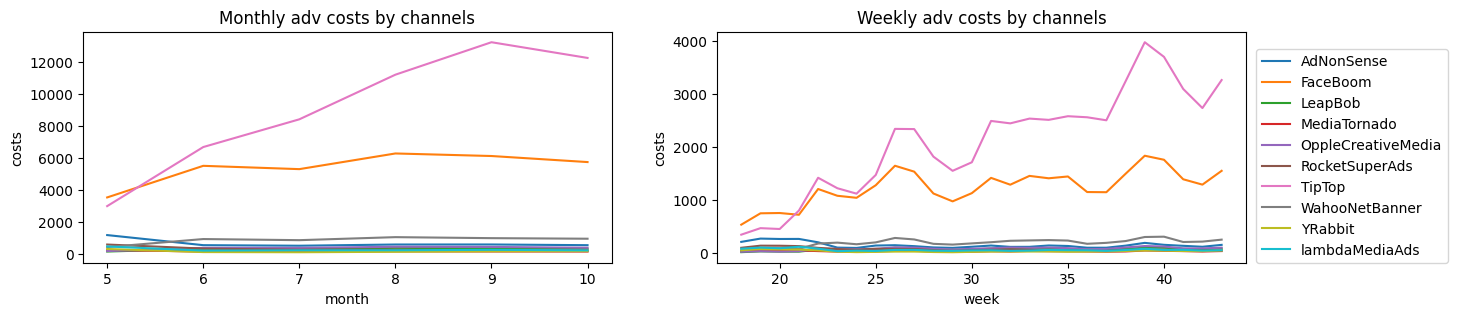

In [55]:
costs_df['dt'] = pd.to_datetime(costs_df['dt'])

# we may don't take in mind a year, because all the data is from 2019 
# add month and week columns 
costs_df['month'] = costs_df['dt'].dt.month
costs_df['week'] = costs_df['dt'].dt.isocalendar().week

plt.figure(figsize=(15,3))

monthly_costs_by_channels = costs_df.groupby(['channel', 'month']).agg({'costs':'sum'}).reset_index()
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Monthly adv costs by channels')
sns.lineplot(data=monthly_costs_by_channels, x='month', y='costs', hue='channel', ax=ax1, legend=None)
# plt.legend(bbox_to_anchor=(0.5, -1.2), loc='lower center', borderaxespad=0)

weekly_costs_by_channels = costs_df.groupby(['channel', 'week']).agg({'costs':'sum'}).reset_index()
ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Weekly adv costs by channels')
sns.lineplot(data=weekly_costs_by_channels, x='week', y='costs', hue='channel', ax=ax2)

plt.legend(bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0)
plt.show()



**Conclusion**
* Promotion spending in all sources except FaceBoom and TipTop remained virtually unchanged over the observed period
* monthly promotion spending in FaceBoom increased in June 2019
* monthly promotion spending on TipTop increased significantly throughout the period (June through September). Already in June, spending on TipTop overtook spending on FaceBoom. In September and October, spending on promotion in TipTop was twice as high as spending on FaceBoom
* the dynamics of weekly spending demonstrates that spending in the TipTop, FaceBoom channels varied for the same reasons, whether it was an increase in advertising activity from the marketing department, or a change in rates in the promotion channel
* weekly promotion spending in TipTop increased much more in week 27 than, faceBoom spending and did not decrease significantly in week 28-29  

### cost to attract one user from each source (CAC) 

In [56]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).reset_index().sort_values('acquisition_cost',ascending=False)

,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


**Conclusion**
* the highest cost of attraction in the TipTop channel. But this was already clear from the previous analysis. 
* The second channel by attraction cost is FaceBoom. But in this channel the cost of attraction is 2.5 times lower. 
* The cheapest attraction channel is LeapBob. But the conversion to paid users in this channel is only 3%.

### return on advertising investment 

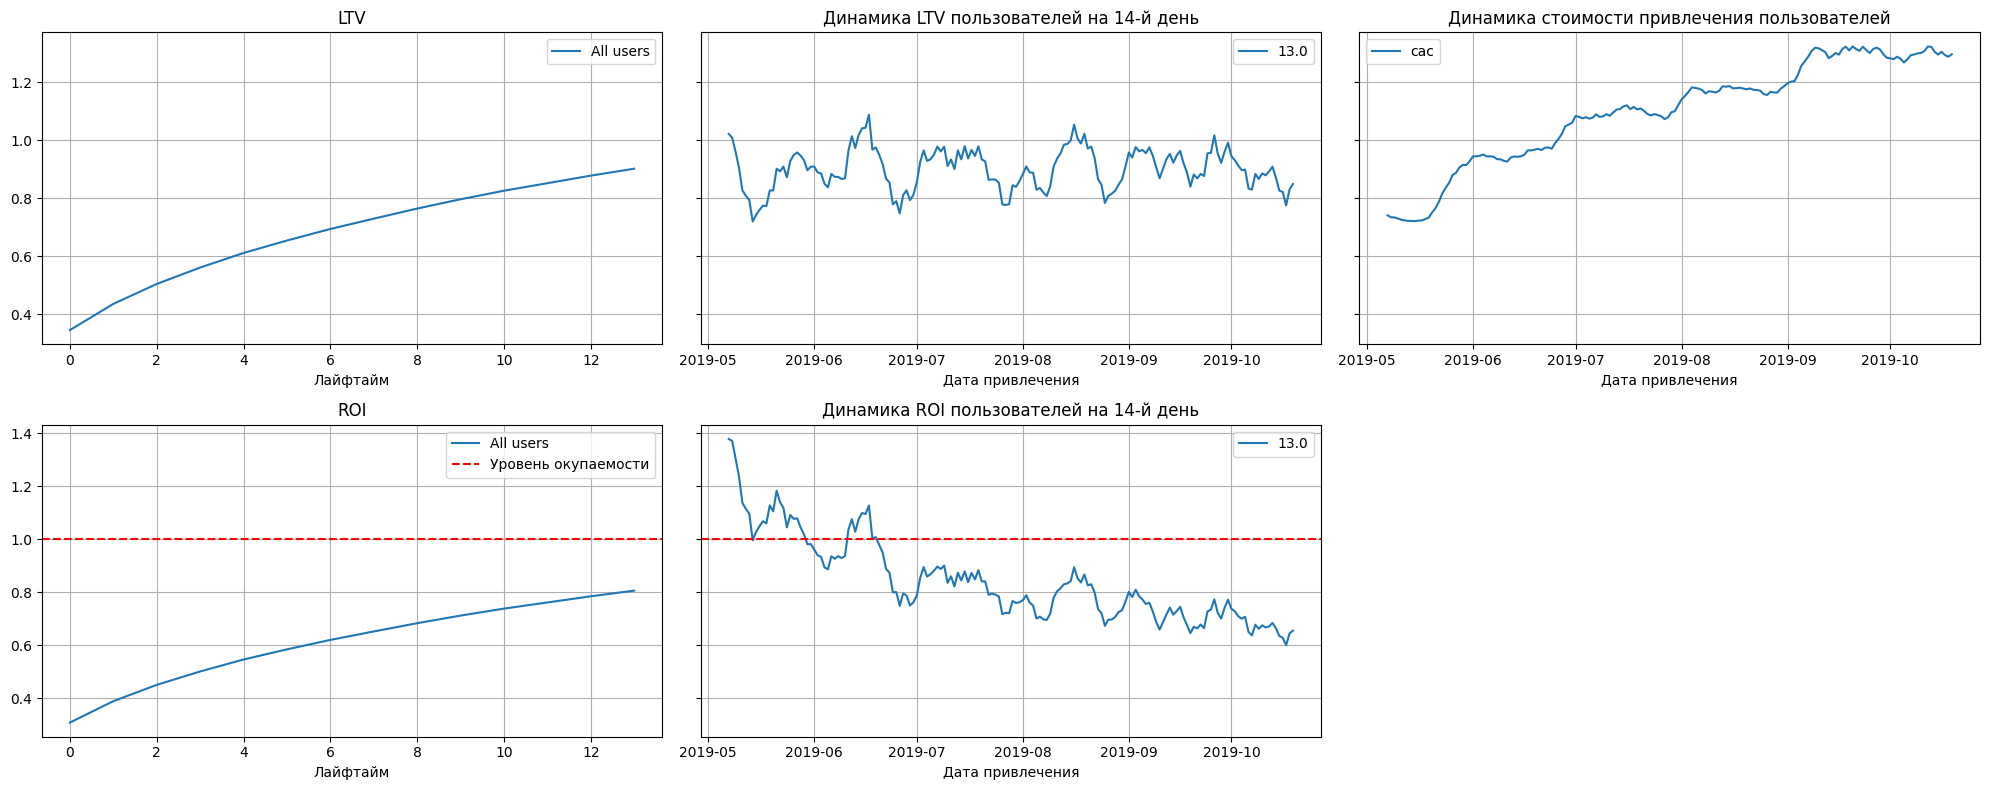

,user_id
month,
2019-05-01,14695
2019-06-01,7808
2019-07-01,7686
2019-08-01,9041
2019-09-01,9024
2019-10-01,8185


In [57]:
observation_date = datetime(2019,11,1).date()
horizon_days = 14

result_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(profiles.query('channel != "organic"'), orders_df, observation_date, horizon_days)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

profiles.query('channel == "organic"').groupby('month').agg({'user_id':'count'})

**Conclusion**
* Because we are analyzing the return on advertising, that is, paid attraction, organic users were excluded from the analysis and analyzed separately
* The LTV of the 14th day averaged 0.9 for all users in the analyzed period. LTV varies during the analyzed period from 0.8 to 1.1
* LTV correlates with ROI. The better we retain customers, the greater the profit. It is worth preparing an action plan to improve user retention
* The cost of user engagement rose in June 2019 continued to rise through the end of the analysis period. It is worth thinking about reducing the cost of attracting new users. This increase is known to be mostly due to the rising cost of engagement in the TipTop channel. 
* At the same time as the rise in ad spending in June, the flow of new organic users dropped. It's worth finding the reason for this and trying to restore May 2019 practices
* the ROI of the 14th day on average for all users during the analyzed period is slightly higher than 0.8. This means that the goal defined by the business plan is not being met in the analyzed timeframe. Investments in attracting new users do not pay off. The break-even point is reached only on day 23.
* The situation is saved by organic users. If you include them in the analysis, the goal of the business plan is achieved on the 14th day. But the number of new organic users decreased in June. From June to October inclusive, the ROI=1 point is not reached on the 14th day.
* ROI in dynamics shows significant fluctuations due to two factors: fluctuating LTV and increasing costs to attract new users. ROI shows a negative trend during the analyzed period. We have to do something urgently. 

*TODO*
* It is worth thinking about reducing the cost of attracting new users. We know that this growth is mostly due to the rising cost of attraction in the TipTop channel.
* It is worth to work with organic users and find the reason for their departure and try to restore the practices used in May 2019

### conversion and retention

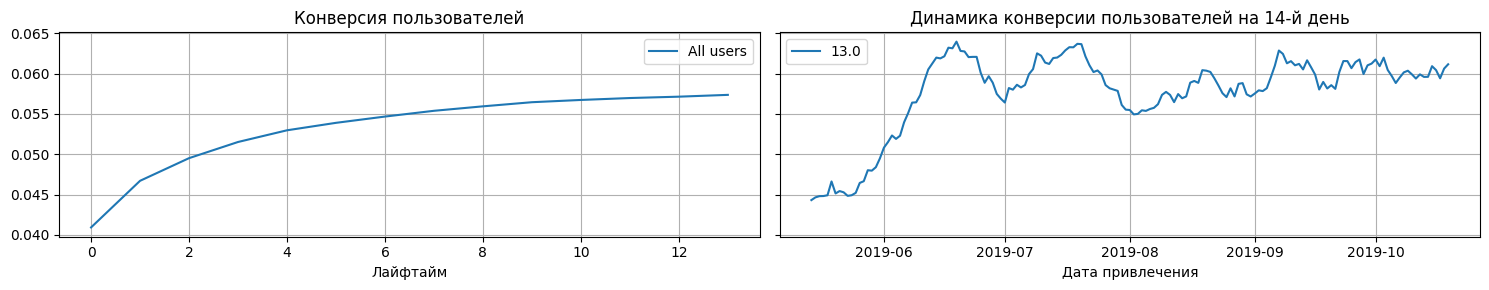

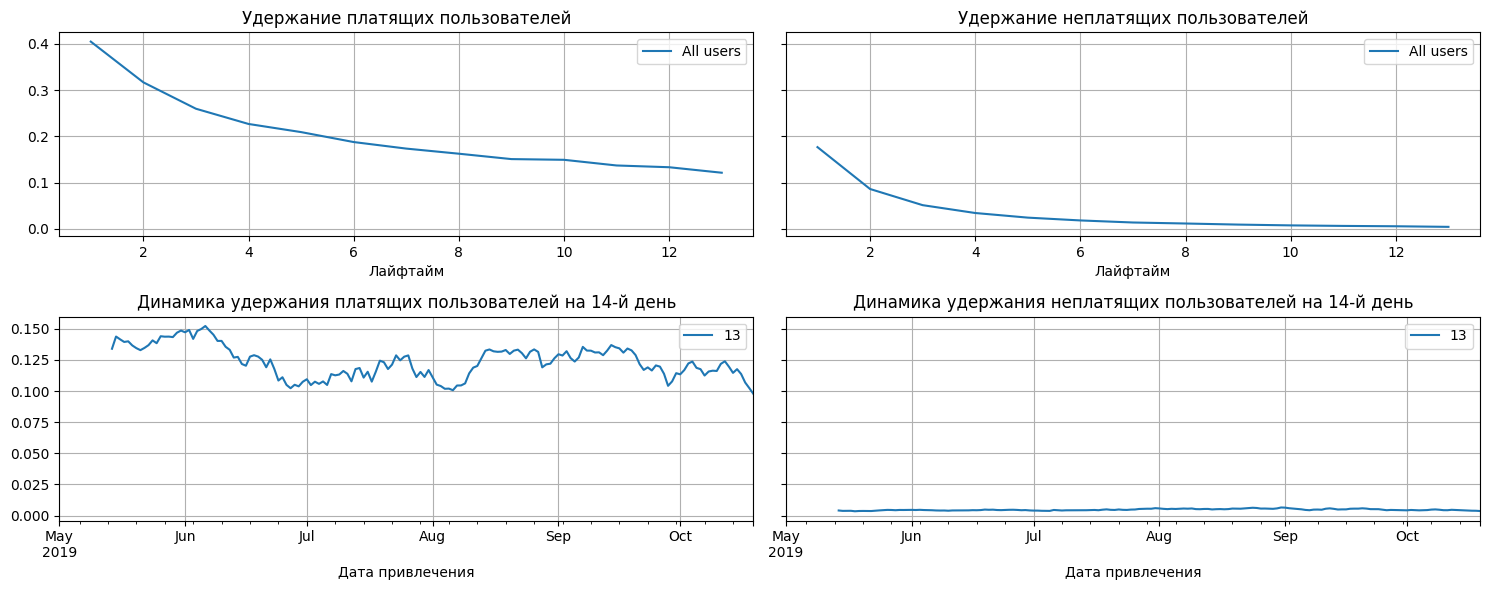

In [58]:
horizon_days = 14

conversion_raw, conversion, conversion_history = get_conversion( profiles.query('channel != "orgarin"'), orders_df, observation_date, horizon_days )
plot_conversion(conversion, conversion_history, horizon_days, window=14)

retention_raw, retention, retention_history = get_retention( profiles.query('channel != "orgarin"'), visits_df, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days, window=14)

**Conclusion:**
* Because we are analyzing the return on advertising, i.e., paid attraction, organic users were excluded from the analysis
* User conversion is growing strongly during the first four days and reaches 5.7% on the 14th day
* conversion rate is up 0.15 relative to May 2019. Learned to convert well. That's great. But conversion remains unstable, fluctuating between 5 and 7%. Either there is an explanation in external factors, or we are not learning from our own successes and failures. It's worth looking at the hindsight of customer acquisition activities. We often manage to attract good converting users
* Paying user retention drops from 40% to 12% within 14 days of use. That's a pretty big drop. And then retention stays pretty much the same at 10%. It's worth thinking about activities to reduce user churn in the first 10 days. Perhaps add a targeted or special offer
* Non-paying users can only be retained for the first 5 days. After that, their retention tends to zero. We have only 5 days to try and turn a non-paying user into a paying one.
* The situation with the retention dynamics of paying users is similar to conversion, but even more pronounced - the retention varies from 5 to 20%. It is worth drawing conclusions from advertising activities. Some of them were better at reaching the clients, who were ready to be retained, and some of them were worse.
*retention of non-paying users on the 14th day does not change over time and is effectively zero

*TODO:*
* It's worth looking at a retrospective of customer acquisition activities. We often manage to attract well converting and well retained users
* Worth thinking about activities to reduce user churn in the first 10 days. Perhaps add a targeted or special offer

### conversion and retention by channels

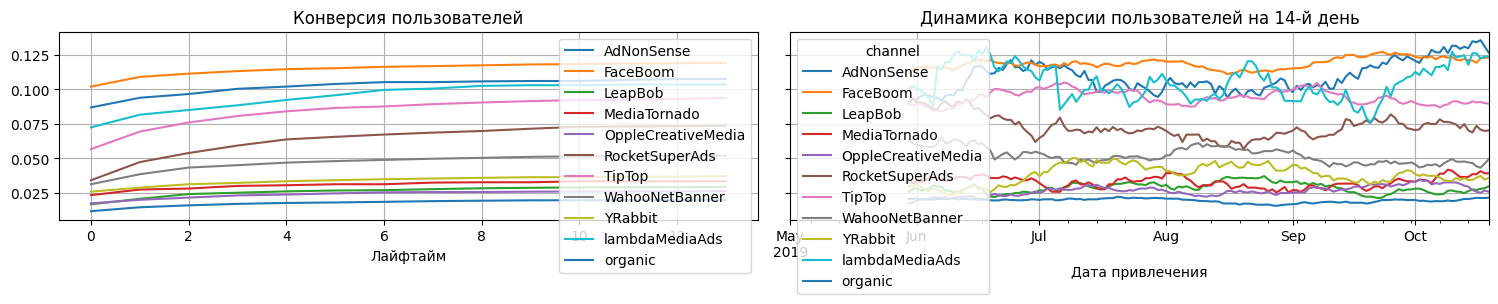

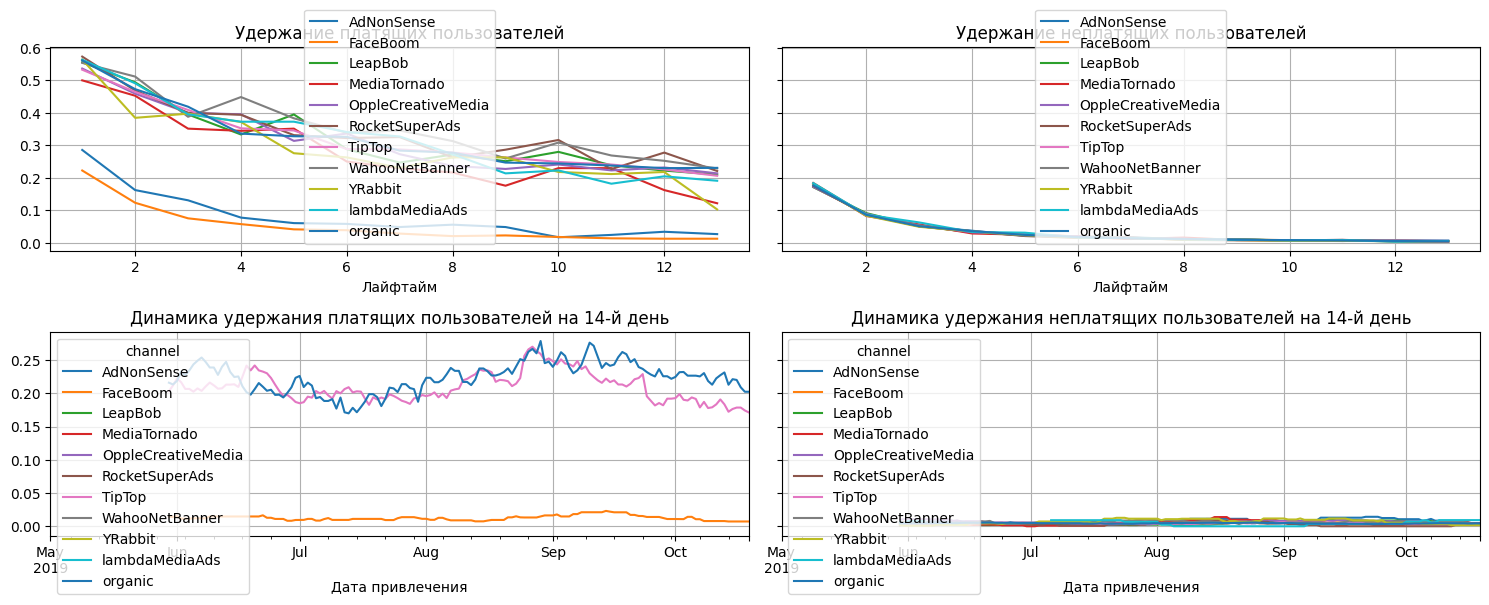

In [59]:
conversion_raw, conversion, conversion_history = get_conversion( profiles.query('channel != "orgarin"'), orders_df, observation_date, horizon_days, dimensions=['channel'] )
plot_conversion(conversion, conversion_history, horizon_days, window=30)

retention_raw, retention, retention_history = get_retention( profiles.query('channel != "orgarin"'), visits_df, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days, window=30)

**Conclusion**
- The highest conversion rate is observed in the FaceBoom channel. At the same time, the overall low customer retention is largely due to advertising in the same FaceBoom channel. Customer retention in this channel is even lower than organic customer retention. There is clearly something wrong with the advertising in this channel

### conversion and retention by countries

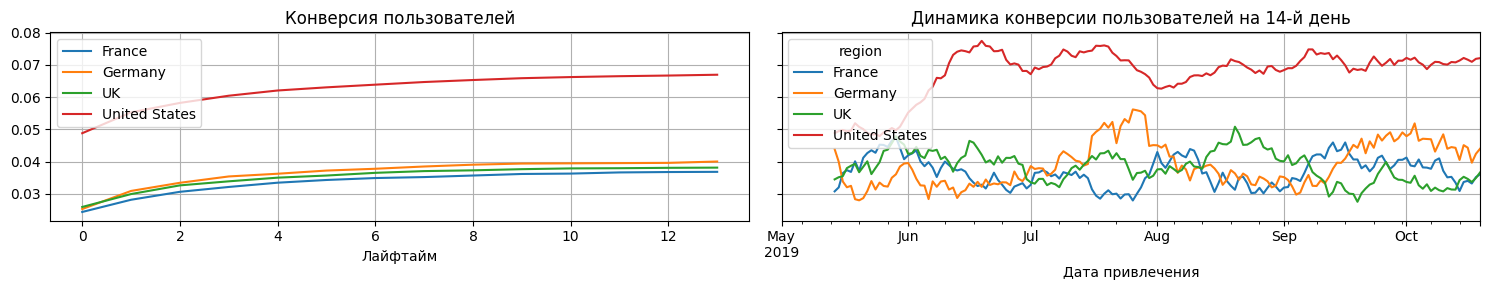

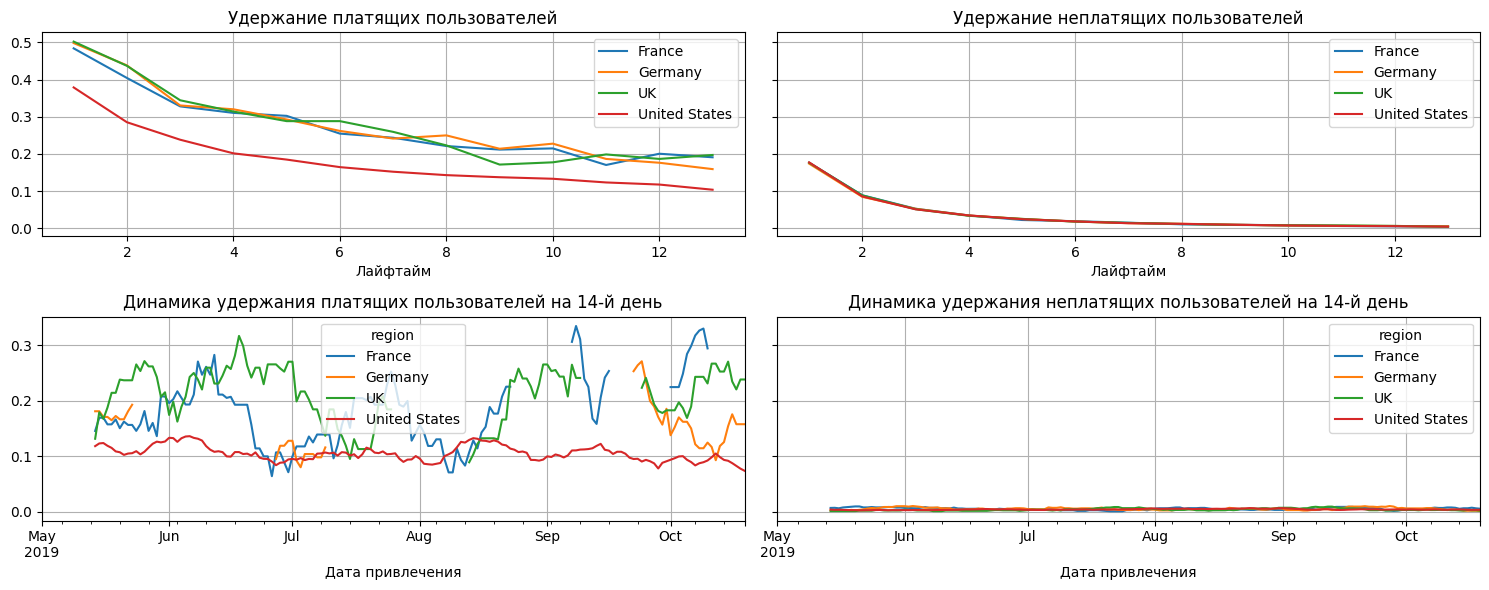

In [60]:
conversion_raw, conversion, conversion_history = get_conversion( profiles.query('channel != "orgarin"'), orders_df, observation_date, horizon_days, dimensions=['region'] )
plot_conversion(conversion, conversion_history, horizon_days, window=14)

retention_raw, retention, retention_history = get_retention( profiles.query('channel != "orgarin"'), visits_df, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention, retention_history, horizon_days, window=14)

**Conclusion**
- the highest conversion rate is observed in the United States. At the same time, U.S. clients have the lowest retention rate. Maybe there is something wrong with the advertising for the US.

### ROI by gadgets

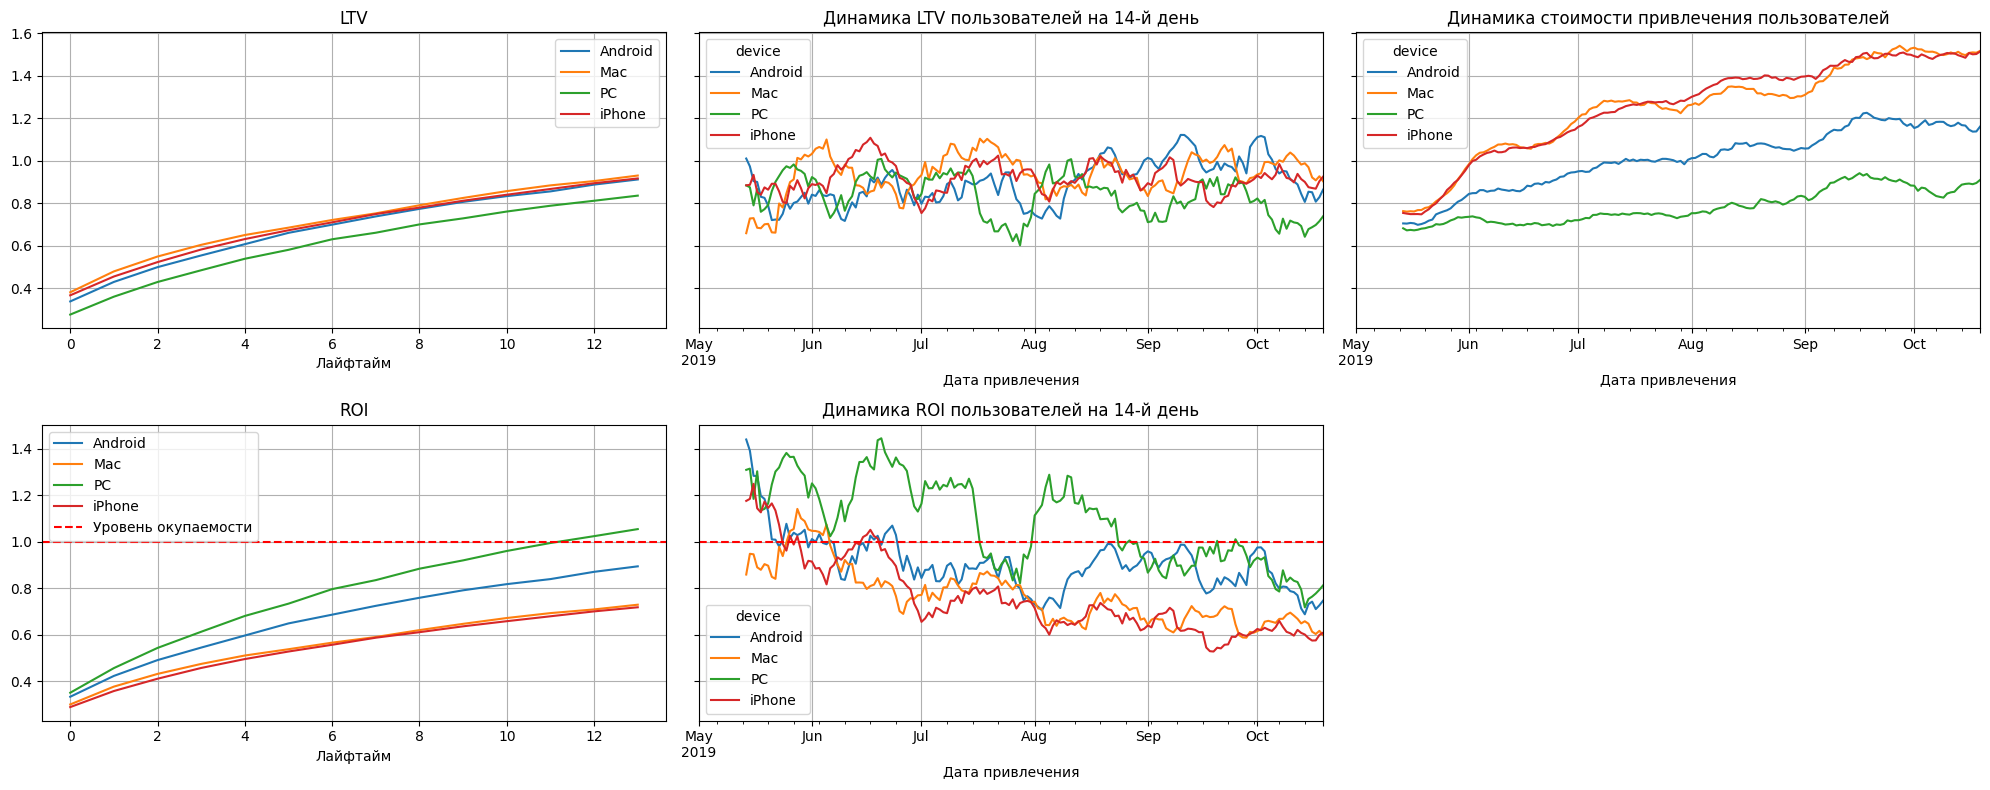

In [61]:
horizon_days = 14

result_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(profiles.query('channel != "organic"'), orders_df, observation_date, horizon_days, dimensions=['device'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

**Conclusion**
* LTV on all devices except PC is about the same (0.9 for day 14). The LTV for the PC is 0.1 lower than for the other devices. However, this was not always the case. Judging by the LTV dynamics, the indicator decreased significantly in mid-July and early September. This also had an effect on ROI for the PC platform. It is necessary to clarify the reasons for the decrease in LTV
* LTV for Android increased significantly in mid-August and remained high until the end of the period. It would be good to figure out what we did right and repeat for the rest of the platforms
* iPhone and Mac platforms have the highest cost of customer engagement. Next comes Android. Rounding out the list is PC. The situation got even worse during the period. The cost of attracting iPhone and Mac users almost doubled. The other platforms also grew, but not as significantly
* The ROI defined in the business plan is only achieved on the PC platform. Android reaches ROI=0.9 on day 14 and is close to the target. Given that LTV does not fluctuate much from platform to platform, the differences in ROI are mainly due to differences in the cost of attracting users on different platforms
*The ROI dynamic confirms previous findings regarding the failure of LTV on PCs and the strong increase in the cost of user engagement on iPhones and Macs

*TODO*:
* we need to focus advertising efforts on more accessible platforms - PC, Android. At the same time, you should try to increase LTV on PC to the same level as on the other platforms.
* if possible, it is worth reducing investment in advertising on Apple platforms

### ROI by counties

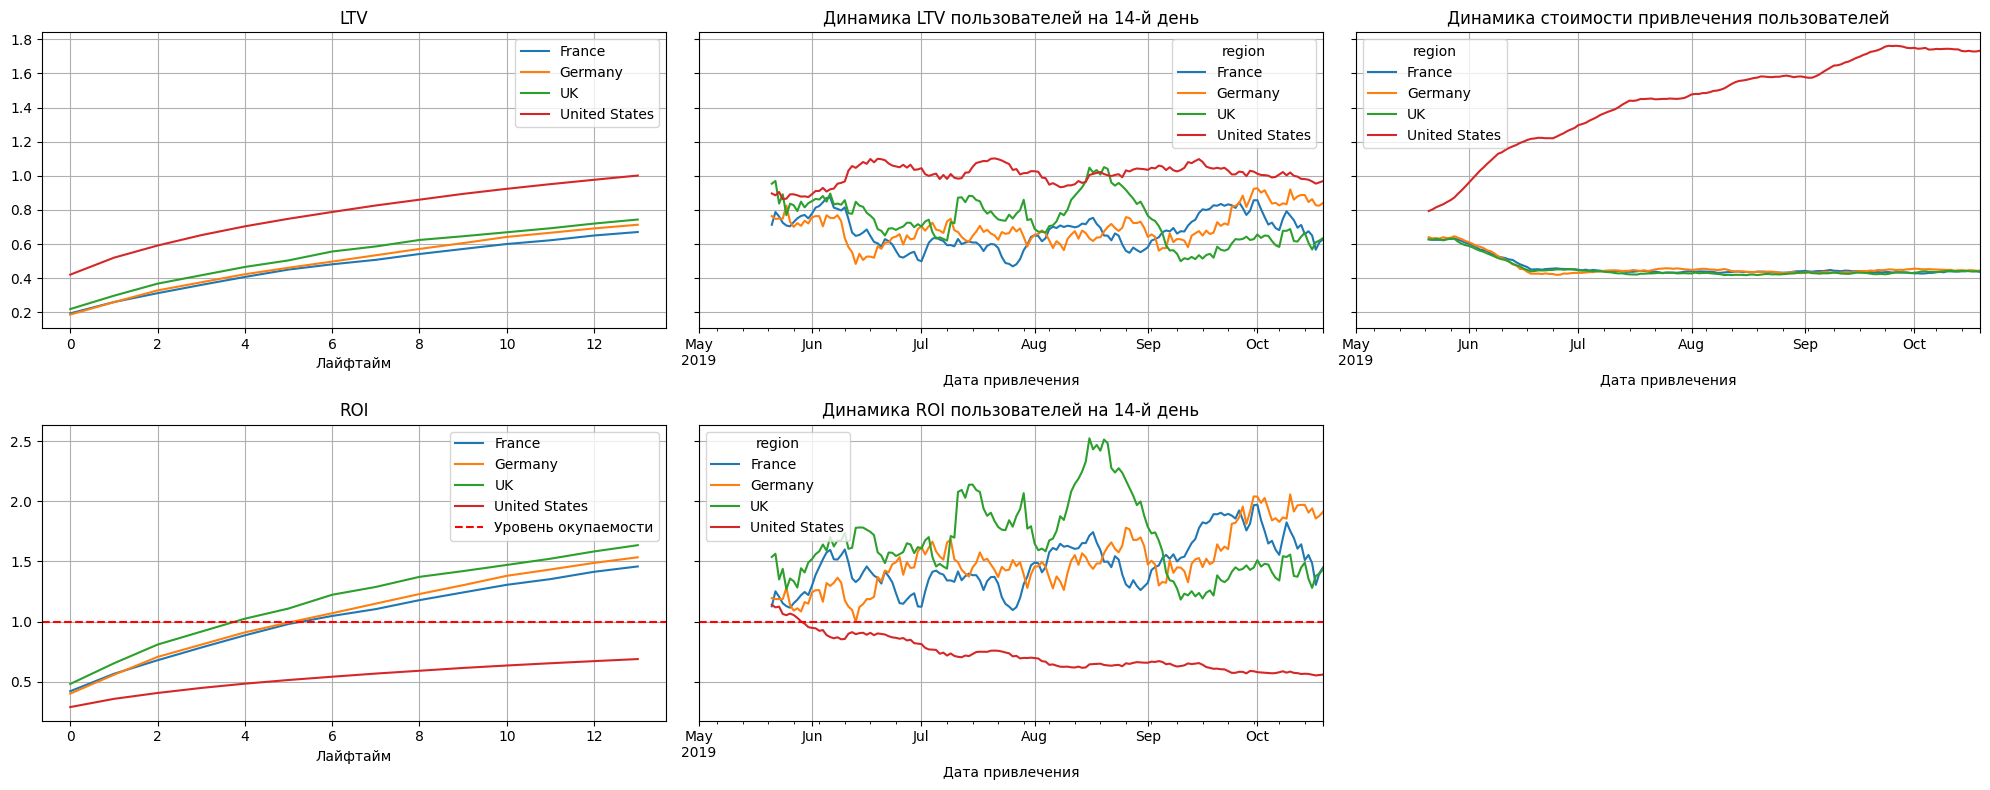

In [62]:
horizon_days = 14

result_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(profiles.query('channel != "organic"'), orders_df, observation_date, horizon_days, dimensions=['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=21)

**Conclusion**
* The highest LTV for the analyzed period was recorded in the United States. Other countries are approximately at the same level. 
* The LTV in the U.S. increased slightly at the beginning of the year, and remained stable thereafter. At the same time, the LTV of UK users began to decrease in August. This is probably a consequence of the LTV growth before that. LTV of users from Germany at the end of the period shows growth
* The cost to acquire users from the United States was growing over the entire period and by the end of the period was four times the cost to acquire users from other countries. The cost of attracting users from other countries dropped on June 1 and has remained stable since then. 
* The planned ROI is reached already on the 5th day in all countries except the USA. This is due to the excessively high cost of attracting users from the U.S. 
* in the dynamics of ROI in the U.S. was not only lower than in other countries, but was declining throughout the period. The relatively high LTV of customers in the U.S. did not save the situation. The other countries had a stable ROI above 1 for the entire period. Given that CAC for the rest of the countries was stable throughout the period, ori moved after LTV. The UK stands out: there were two ROI peaks, in mid-July and mid-August, caused by rising LTV. It is worth remembering what could have caused them. 

*TODO*
* it is worth focusing advertising efforts on countries where the cost of attraction allows businesses to earn Germany, France, UK
* reduce advertising costs for U.S. customers. For one customer from the US, you can get 4 customers in another country

### ROI by advertising channels

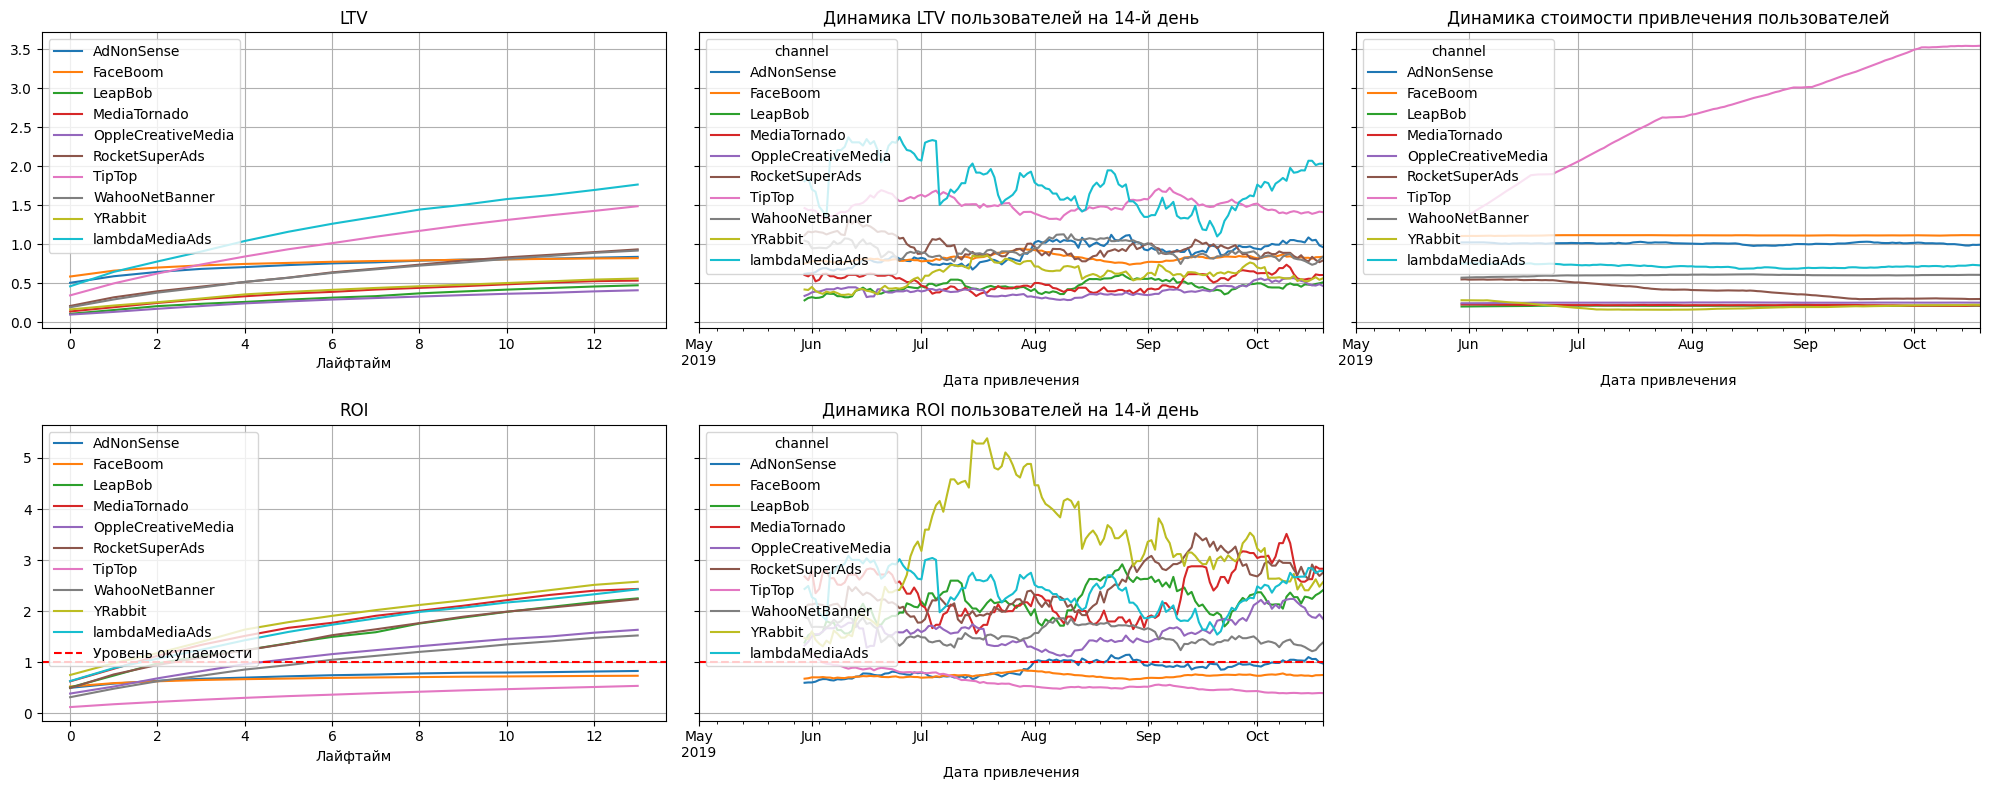

In [63]:
horizon_days = 14

result_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(profiles.query('channel != "organic"'), orders_df, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

**Conclusion**
* The highest LTV of users attracted through the lambdaMediaAds channel. In second place is TipTop. Users from the OppleCreativeMedia channel have the lowest LTV
* LTV dynamics is very volatile regardless of the channel. It can be noted that there is no increase or decrease of LTV in any of the channels. The LTV of the lambdaMediaAds channel is the least stable: there was a noticeable increase in June and from mid-September to the end of the analyzed period, and a decrease in July. 
* The cost of attracting users was stable in all channels with the exception of TipTop. TipTop's CAC by the end of the analyzed period is 3.5 times higher than that of the next channel, FaceBoom. The cost of engagement in the TipTop channel increased by more than 3 times over the period
* The highest ROI are shown by users attracted through the channels YRabbit, MediaTornado, lambdaMediaAds. The cost of attracting users pays off in all channels within 14 days except TipTop, FaceBoom, AdNonSense. You should be cautious when investing in advertising in these channels.
* There are no significant trends in the dynamics of ROI. There was one abnormal increase in ROI from the beginning of the period to mid-July for users in the YRabbit channel. Caused by a decrease in CAC and a simultaneous increase in LTV. 

*TODO* 
* increase investment in YRabbit, MediaTornado, lambdaMediaAds channels
* reduce or completely stop attracting customers through TipTop, FaceBoom, AdNonSense channels

## Overall conclusion

Questions from Marketing dept:
- *Does advertising aimed at attracting users generally pay for itself?*
    In general, advertising does not pay for itself within the 14 days stipulated in the business plan. The payback period for the advertising investment is 23 days.
- *What devices, countries, and advertising channels can have a negative impact on advertising ROI?*
    Advertising ROI can be negatively impacted by:
    - Mac and iPhone devices
    - countries: US
    - Ad channels: TipTop, FaceBoom, AdNonSense
- *What can be caused by problems with ROI?*
    Problems may be caused by:
    - Wrong channels set up to attract customers based on LTV and effective demand only but without considering the cost of attracting customers
    - The high cost of attracting customers set by the channel (including the arrival of a competitor and, consequently, higher rates per impression)
    - problems with the product (application) leading to poor conversion of clients to paying ones
    - lack of measures to retain and develop customers in the application 
    - Poor advertisement setup (inappropriate channel for the target audience of the application, wrong targeting settings, poorly formulated application) 

**General recommendations**
* Worth thinking about activities to reduce user churn in the first 10 days. Perhaps add a targeted or special offer. In general, increasing retention could significantly reduce the risks of not recouping your advertising investment
* It's worth working with organic users and finding the reason for their departure and trying to restore May 2019 practices. It is because of organic May users that businesses in general are reaching their ROI targets 

**Recommendations for the advertising department**
- It's worth conducting regular evaluations of the effectiveness of advertising activities, drawing conclusions from successes and failures, and applying that knowledge to future activities 
- recommendations by devices
    * you should focus your advertising efforts on more accessible platforms - PC, Android. At the same time, you should try to increase LTV on the PC to the level of the other platforms.
    * if you can not reduce the cost of attracting customers in the U.S. (where there are a lot of Apple devices), you should think about reducing investment in advertising on the platforms of Apple
- recommendations by countries
    * check ad settings for the US. U.S. customers have very good conversions, but poor retention. Maybe we are promising them something and not fulfilling the promise...
    * if we can't increase the retention of US clients, reduce the advertising spend on US clients. For one customer from the U.S., you can get 4 customers in another country
    * it is worth focusing your advertising efforts on countries where the cost of attraction allows businesses to earn Germany, France, UK
- recommendations by channels
    * assess the possibility of increasing investment in YRabbit, MediaTornado, lambdaMediaAds channels
    * check your FaceBoom ad settings. This channel has too low retention, although the conversion rate is high. Possible errors in targeting or advertising message 
    * Review ways of attracting customers through the TipTop channel. For the cost of attracting one customer in the TipTop channel, you can now attract at least three customers in any other channel. Perhaps we are advertising on too expensive queries. If we can adjust the targeting more accurately, the cost of attracting customers may go down 